<table style="width:100%"><tr>
<td> 
    
<b>Technische Universität Dortmund</b>    
Department of Bio- and Chemical Engineering\
Chair of Process Dynamics and Operations\
Prof. Dr. Sergio Lucia </td>
<td>  <img src="./support_files/figures/tudo_logo.png" style="width: 60%;" align="right"/> </td>
</tr>
</table>

# Advanced Process Control - Tutorial 05
WS 2020 / 2021

### Please click here!

This should start a live explantion. If you don't hear any sound, please check
- volume
- do you have [Jupyter Graffiti](https://github.com/willkessler/jupytergraffiti) installed?
- Please use Chrome or Firefox

#  Questions 1
What are different types recursive nonlinear estimators presented in the lecture?

<span class="graffiti-highlight graffiti-id_p5rjkxf-id_omeq5kl"><i></i><button>Show Solution</button></span>

# Question 2
Recall briefly different recursive nonlinear estimators presented in the lecture.

<span class="graffiti-highlight graffiti-id_dd1xlnj-id_c4sa1ss"><i></i><button>Show Solution</button></span>

# Question 3
List the advantages and disadvantages of the discussed recursive nonlinear estimators.

<span class="graffiti-highlight graffiti-id_u2hez1u-id_m5nqppb"><i></i><button>Show Solution</button></span>

# Question 4
Draw a block diagram of a gain-scheduled Luenberger observer. How are the closed-loop dynamics chosen?

<span class="graffiti-highlight graffiti-id_p7hf891-id_lq6l35g"><i></i><button>Show Solution</button></span>

# Question 5
Compare Extended Kalman Filter and a Moving Horizon Estimator.

<span class="graffiti-highlight graffiti-id_dmc8eud-id_yzzd4yu"><i></i><button>Show Solution</button></span>

# Implementation of Nonlinear State Observers

Consider a continuously stirred tank reactor (CSTR) with a reaction

\begin{align}
\begin{split}
A \overset{k_{AB}}{\Longrightarrow} B \\
2B \underset{k_{CB}}{\overset{k_{BC}}{\rightleftharpoons}} C.
\end{split}
\end{align}

Assume that the total volume entering is equal to the volume
leaving the system: $\dot V_{in}=\dot V_{out}=\dot V=const$. 

The input of the system is the concentration of component $A$ at the
reactor inlet ($c_{Ain}$) , the measured outputs are the concentrations
of component $B$ ($c_B$) and $C$ ($c_C$). The component balances are:
\begin{eqnarray}
\frac{d}{dt} c_A & = & \frac{\dot V }{V_R}(c_{Ain}-c_A)-k_{AB}c_A\\
\frac{d}{dt} c_B &=& -\frac{\dot V }{V_R} {c_B} + k_{AB} c_A + k_{CB} c_C -
k_{BC} {c_B}^2\\
\frac{d}{dt} c_C &=& -\frac{\dot V}{V_{R}} c_C + k_{BC} {c_B}^2 - k_{CB} c_C
\end{eqnarray}

The plant parameter values are given as $k_{AB} = 0.4,\, k_{BC} = 3, \,k_{CB} = 2, \, \dot{V} = 1, \, V_R = 10, \, c_{Ain} = 1$. It is assumed that the exact value of the parameter $k_{AB}$ is not known.

In this tutorial, a discrete Extended Kalman Filter (EKF) shall be designed to observe the unmeasurable concentrations $A$ and the unknown parameter $k_{AB}$. It is assumed that the initial conditions are:
\begin{align*}
		\mathbf{x}_0 = \begin{pmatrix} c_{A,0} \\ c_{B,0} \\ c_{C,0} \\ k_{AB,0} \end{pmatrix} = \begin{pmatrix} 0.1 \\ 0.1 \\ 0.1 \\ 0.1 \end{pmatrix}
\end{align*}
The covariance matrix of the measurement $R$ is known:
\begin{align*}
		\mathbf{R} = \begin{pmatrix}10^{-4} & 0 \\ 0 & 10^{-4} \end{pmatrix}
\end{align*}
The system is fully observable in the region of attainable states.


## Task 1: Import required packages

The python packages required for this task are casadi, matplotlib.pyplot and numpy 

In [1]:
# display, Markdown from Python.display
from IPython.display import display, Markdown
# Import everything (*) from casadi
from casadi import *
# import matplotlib for plotting:
import matplotlib.pyplot as plt
# And numpy to perform matrix and array opearations
import numpy as np

<span class="graffiti-highlight graffiti-id_vmgcx20-id_phtvec1"><i></i><button>Show Solution</button></span>

## Task 2: Simulate and plot the plant measurements along with the plant states

#### Task 2.1: Plant Parameters

Generate a dictionary variable which contains all the plant parameters

In [2]:
# Plant parameters
kAB =0.4;
kBC =3.0;
kCB =2.0;
Vdot =1.0;
VR =10.0;
cAin = 1.0;

# Dictionary variables which contains all the parameters
parameters = {'kAB':kAB, 'kBC':kBC, 'kCB':kCB, 'Vdot':Vdot, 'VR':VR, 'cAin':cAin}

<span class="graffiti-highlight graffiti-id_xrjcv8n-id_0i3b0na"><i></i><button>Show Solution</button></span>

#### Plant measurements and Initial conditions

It is given that only $c_B$ and $c_C$ are measured. How does the measurement matrix $C$ and the intial condition $\mathbf{x}_0$ look like? Declare it as casadi DM variable.

In [3]:
# Measurement Matrix
C = DM([[0, 1, 0, 0], [0, 0, 1, 0]]); 

# Initial Condition of Plant
x0 = DM([0.2, 0.3, 0.1]);

<span class="graffiti-highlight graffiti-id_27lo296-id_y5evdqd"><i></i><button>Show Solution</button></span>

#### Task 2.2: Plant model
Genearate a python function which takes the plant parameters as input arguements and returns the differential equation and the state variables as casadi symbolic expressions.

<strong> Note: </strong> Only to generate the plant measurements you consider the value $k_{AB}$ given in the exercise. While designing the obserserver you assume it is unknown and estimate it along with the unmeasured state using the observer.

In [4]:
def plant_model(parameters):
    # Extract the plant parameters from the input dictionary
    kAB = parameters['kAB']; 
    kBC = parameters['kBC'];
    kCB = parameters['kCB'];
    Vdot = parameters['Vdot'];
    VR = parameters['VR'];
    cAin = parameters['cAin'];
    
    # Generate state variable as symbolic variables
    cA = SX.sym("cA")
    cB = SX.sym("cB")
    cC = SX.sym("cC")

    # Concatenate the symbolic variables to form a state vector
    x = vertcat(cA,cB,cC)
    
    # Generate the differential experssion based on the equations given in the questions
    dcA = Vdot/VR*(cAin - cA) - kAB*cA;
    dcB = -Vdot/VR * cB + kAB*cA + kCB*cC - kBC*cB**2;
    dcC = -Vdot/VR * cC + kBC*cB**2 - kCB*cC;

    # Concatenate the differential expressions
    dx = vertcat(dcA, dcB, dcC)
    
    return x, dx

<span class="graffiti-highlight graffiti-id_f1qw7g4-id_ngxg6bz"><i></i><button>Show Solution</button></span>

#### Task 2.3: Generating plant measurements

Create a python function which uses the above plant model function to generate the plant measurements. The python function takes a set of input arguments and returns the plant measurments, plant states and time vector as output arguments. A short description of the input and outbut arguments are given below

| Input arguments | Description |       
| :------------- |:-------------| 
| x0      | Intial condition of the states|
| parameters      | Dictionary variable which contains the plant parameters     |
| integeration_step | Sampling time of the plant      |
| endtime | Contains the time until which the plant measurements has to be simulated      |
| R | Measurement error covariance matrix     |

| Output arguments | Description |       
| :------------- |:-------------| 
| t_meas      | All the points in time domain for which the plant measurements is simulated|
| plant_measurement | Simulated plant measurement      |
| plant_state      | True value of the plant states      |

Complete the missing lines of code in the python function

<strong> Note: </strong> Casadi integerators are used to generate the plant measurements. 

In [5]:
def simulate_plant_measurement(x0, parameters, integeration_step, endtime, R):
    # Call the plant model function to obtain the state symbolic variable and the differential equations
    x, dx = plant_model(parameters)

    
    # Dictionary variable which contains the state variable and differential variable to be sent to the integerator
    ode = {'x':x, 'ode':dx}
    
    # Create a time using np.linspace to obtain the time grid for which plant states should be simulated
    t_meas  = np.linspace(0, endtime, int(endtime/integeration_step)+1)

    # Casadi integerateor Integerator (Use "cvodes" for ODE and "idas" for DAE)
    # Integerator options
    opts = {"abstol": 1e-10, "reltol": 1e-10,'grid': t_meas}
    
    # Setup the integerator
    plant_simulator = integrator("plant", 'cvodes', ode, opts)
    
    # Call the integerator
    result = plant_simulator(x0=x0)
    
    # Extract the plant states from the integerator results and add the intial condition to the extracted states-
    plant_state = vertcat(x0.T, result['xf'].T)

    # Extract only the measurement vector from the states
    plant_measurement = result['xf'][1:3,:].T
    
    # Add the initial plant measurements to the simulated plant measurements
    plant_measurement = vertcat(x0[1:3].T, plant_measurement)

    # Generate random variables to simulate measurement noise
    np.random.seed(10) # To generate the same plant measurement everytime when you run the code. Remove this line if you want new measurements to ge be generated.
    meas_error = np.random.randn(plant_measurement.shape[0], plant_measurement.shape[1]) # Generates gaussian measurement noise
    meas_error = mtimes(meas_error, sqrt(R)) # Scale the measurement noise according to the measurement covariance matrix

    # Add measurement noise to the plant measurements
    plant_measurement = plant_measurement + meas_error;

    return t_meas, plant_measurement, plant_state

<span class="graffiti-highlight graffiti-id_0dy7um4-id_sjdy356"><i></i><button>Show Solution</button></span>

#### Task 2.4: Simulating plant measurements and plotting

Choose the final time (<em>endtime</em>) as 10 and the sampling time (<em>integeration_step</em>) as 0.1 and call the python function <em> simulate_plant_measurement()</em> to generate the plant measurements. Plot the plant measurements.

Plant Measurements:

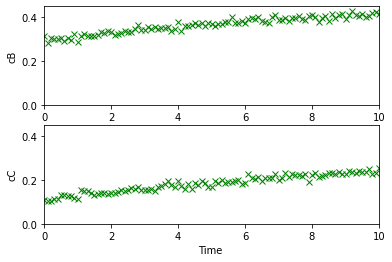

In [6]:
# Endtime
endtime = 10;

# Simulation step width
integeration_step  = 0.1;               

# Measurment Noise covariance matrix as casadi DM Variable
R = DM([[0.0001, 0.], [0., 0.0001]]);
        
# Call the python function to generate the plant measurements
t_meas, plant_measurement, plant_state = simulate_plant_measurement(x0, parameters, integeration_step, endtime, R)

# Plot the plant measurments 
display(Markdown('Plant Measurements:'))
plt.figure()
plt.ion()
plt.subplot(211)
plt.plot(t_meas,plant_measurement[:,0], 'gx')
plt.ylim([0., 0.45])
plt.xlim([0., endtime])
plt.ylabel('cB')
plt.subplot(212)
plt.plot(t_meas,plant_measurement[:,1], 'gx')
plt.ylim([0., 0.45])
plt.xlim([0., endtime])
plt.ylabel('cC')
plt.xlabel('Time ')
plt.show()

<span class="graffiti-highlight graffiti-id_qcz4vmg-id_xbrj98u"><i></i><button>Show Solution</button></span>

## Task 3: Implemenation of Discrete Extended Kalman Filter

The first and foremost thing one has to do before desiging a observer is to check the observability condition using the Kalman or Hautus criterion. If the condition is satisfied. it is principally says that it possible to observe the system states (independent from the observer). Since its given that the system is fully observable in the region of attainable states we skip this step. 

#### Parameter estimation using state observer

According to the above introduced idea of an observer, only states that are part of an observable system can be estimated. Model parameters like the reation rate ($k_{AB}$) though of interest, is not a state, hence it cannot be estimated offhand. But a simple trick can be used to convert a general parameter to a state variable. This is accomplished by the introduction of <em>dummy</em> derivative. Let $\mathbf{d}$ be a vector of uncertain parameters.
\begin{equation}
\dot{\mathbf{d}}=0
\end{equation}
\begin{equation}
\mathbf{d}(0)=\mathbf{d}_0
\end{equation}

As long as no information on the dynamics of the unknown input or parameter are known, those are set constant by a "dummy" (zero) derivative. An augmented system can be set up by combining the plant equations are given by:

\begin{eqnarray}
\frac{d}{dt} c_A & = & \frac{\dot V }{V_R}(c_{Ain}-c_A)-k_{AB}c_A\\
\frac{d}{dt} c_B &=& -\frac{\dot V }{V_R} {c_B} + k_{AB} c_A + k_{CB} c_C -
k_{BC} {c_B}^2\\
\frac{d}{dt} c_C &=& -\frac{\dot V}{V_{R}} c_C + k_{BC} {c_B}^2 - k_{CB} c_C \\
\frac{d}{dt} k_{AB} &=& 0
\end{eqnarray}

The observer must now be designed for the augmented system, which must be still observable, i.e. only parameters which influence the measured variables can be estimated. Additionally, it can also be shown that for each unknown parameter, at least one measurement is needed. It is given in the question that the augmented system is observable.

#### Task 3.1: Discretized observer model

The ODE system can be transformed to a discrete-time system by applying the finite difference approach. The system can be rewritten as:
\begin{align*}
{\mathbf x}_{k+1} = \mathbf x_k + \Delta t \cdot \left( \begin{array}{c} 
\frac{\dot{V}}{V_R}c_{A0}-\frac{\dot{V}}{V_R}x_{k,1}-x_{k,4}x_{k,1} \\
x_{k,4}x_{k,1}-\frac{\dot{V}}{V_R}x_{k,2}-k_{BC}x_{k,2}^2+k_{CB}x_{k,3} \\
k_{BC}x_{k,2}^2-\frac{\dot{V}}{V_R}x_{k,3}-k_{CB}x_{k,3} \\
0 \\
\end{array}\right)
\end{align*}	
with $$ \mathbf{x}_k = [c_A,\;c_B,\; c_C,\; k_{AB}]^T.$$

Create a python function which returns the discrtetized the observed model equations along with the linearized system matrix. A short description of the input and output arguments are given below

| Input arguments | Description |       
| :------------- |:-------------| 
| parameters      | Dictionary variable which contains the plant parameters      |
| integeration_step | Sampling time of the plant      |

| Output arguments | Description |       
| :------------- |:-------------| 
| x_k      | Casadi symbolic variable which describes the state at time $k$ of the discretized system |
| x_k1 | Casadi symbolic variable which describes the state at time $k+1$ of the discretized system      |
| A_k      | Casadi symbolic variable which describes the linearized system matrix of the nonlinear discrete time system      |

Complete the missing lines of code in the python function

<strong> Note: </strong> The jacobian of a function can be calculated using the <em> jacobian() </em> casadi function

In [7]:
def discrete_observer_model(parameters, integeration_step):
    # Extract the plant parameters from the input dictionary
    kBC = parameters['kBC'];
    kCB = parameters['kCB'];
    Vdot = parameters['Vdot'];
    VR = parameters['VR'];
    cAin = parameters['cAin'];

    # Generate state variable as symbolic variables
    cA = SX.sym("cA")
    cB = SX.sym("cB")
    cC = SX.sym("cC")
    kAB = SX.sym("kAB");

    # Concatenate the symbolic variables to form a state vector
    x = vertcat(cA,cB,cC,kAB)

    # Give the differential equation of the observer model
    dcA = Vdot/VR*(cAin - cA) - kAB*cA;
    dcB = -Vdot/VR * cB + kAB*cA + kCB*cC - kBC*cB**2;
    dcC = -Vdot/VR * cC + kBC*cB**2 - kCB*cC;
    dkAB = 0

    # Concatenate the differential expressions
    dx = vertcat(dcA, dcB, dcC, dkAB)

    # Forward finite difference approximation
    # State variable at time k
    x_k = x
    
    # State variable at time k+1
    x_k1 = dx*integeration_step + x_k

    # Linearized system matrix of the nonlinear discretized observer model 
    A_k = jacobian(x_k1, x_k)

    return x_k, x_k1, A_k

<span class="graffiti-highlight graffiti-id_2e63ppt-id_3te729g"><i></i><button>Show Solution</button></span>

#### Task 3.2: Discrete Extended Kalman Filter Algorithm

Consider the following nonlinear dynamic system:
\begin{align}
\mathbf{x}_{k+1} &= \mathbf{f}(\mathbf{x}_k,\mathbf{u}_k) + \mathbf{w}_k \\
\mathbf{x}(0) &= \mathbf{x}_0 + \mathbf{w}_0\\
\mathbf{y}_k & = \mathbf{h}(\mathbf{x}_k) + \mathbf{v}_k
\end{align}
$\mathbf{w}_k$ and $\mathbf{v}_k$ are assumed to be
<ul>
<li>zero mean: $E(\mathbf{w}) = E(\mathbf{v}) = 0$ </li>
<li>uncorrelated: $E(\mathbf{w}_i,\mathbf{w}_j) = E(\mathbf{v}_i,\mathbf{v}_j) = 0 \quad \forall i\neq j$ </li>
<li>distributed according to a normal distribution with covariance matrices $\mathbf{Q}$ $(\mathbf{w}_k)$, $\mathbf{R}$ $\mathbf{v}_k)$ and $\mathbf{P}_0$ $(\mathbf{w}_0))$</li>
<ul>
    
The algorithm of the discrete EKF can be divided into two steps:
<ul>

<li> <u>Correction or Measurement update </u></li>
\begin{align}
\mathbf{K}_k &= \mathbf{P}_{k,k-1} \: \mathbf{C}^T_{k,k-1}\left(\mathbf{C}_{k,k-1}\mathbf{P}_{k,k-1}\mathbf{C}^T_{k,k-1}+\mathbf{R}\right)^{-1}\\
\hat{\mathbf{x}}_{k,k} &= \hat{\mathbf{x}}_{k,k-1}+\mathbf{K}_k\left(\mathbf{y}_k-\mathbf{h}(\hat{\mathbf{x}}_{k,k-1})\right)\\
\mathbf{P}_{k,k} &= \left(I-\mathbf{K}_k\mathbf{C}_{k,k-1}\right)\mathbf{P}_{k,k-1}
\end{align}
    
<li> <u> Prediction or Time update </u> </li>
    
Based on the last corrected estimate (filtered state) $\hat{\mathbf{x}}_{k,k}$, the states for the next step are predicted by the model equations without considering disturbances:
\begin{align}
\hat{\mathbf{x}}_{k+1,k}=\mathbf{f}(\hat{\mathbf{x}}_{k,k},\mathbf{u}_{k})
\end{align}
Furthermore, the covariance matrix of the estimation error is predicted for the next sample time:
\begin{align}
\mathbf{P}_{k+1,k}=\mathbf{A}_{k,k}\mathbf{P}_{k,k}\mathbf{A}_{k,k}^T + \mathbf{Q}
\end{align}
with:
\begin{align}
\mathbf{A}_{k,k} = \left.\frac{\partial \mathbf{f}}{\partial \mathbf{x}}\right|_{\hat{\mathbf{x}}_{k,k},\mathbf{u}_k} \qquad \mathbf{C}_{k,k-1} = \left.\frac{\partial \mathbf{h}}{\partial \mathbf{x}}\right|_{\hat{\mathbf{x}}_k,k}
\end{align}
The variable $\hat{\mathbf{x}}_{k,k-1}$ represents the estimated state at time $t=k$, that is calculated from available measurements up to time $t={k-1}$.
<ul>

##### Effect of the tuning parameters ($\mathbf{Q}$, $\mathbf{R}$, $\mathbf{P}_0$):
    
$\mathbf{Q}$ can be interpreted as a weighting factor for the model accuracy. Decreasing the values of the elements of $\mathbf{Q}$ yield a larger weight of the model equations, i.e. the model is assumed to be more accurate. 
    
$\mathbf{R}$ can be interpreted as a weighting factor for the reliability of the measurement. Decreasing the values of the elements of $\mathbf{R}$ yield in an increasing weight of the concerning measurements, i.e. the measurement is assumed to be more reliable.

The covariance matrix of the initial error $\mathbf{P}_0$ has a large influence on the initial convergence behaviour of the EKF and can be interpreted as a weighting factor of the initial guess, i.e. small values of the elements of $\mathbf{P}_0$ imply a high accuracy of estimate. 


Create a python function which uses the above discrete Extended Kalman Filter algorithm to measure the unobservable states and unknown parameters. A short description of the input and output arguments are given below

| Input arguments | Description |       
| :------------- |:-------------| 
| x0_initguess      | Initial guess for the observer states|
| P0      | EKF Tuning parameter - Initial error covariance     |
| Q | EKF Tuning parameter - State noise covariance matrix      |
| R | EKF Tuning parameter - Measurement noise covariance matrix        |
| x0 | Intial condition of the states    |
| parameters      | Dictionary variable which contains the plant parameters     |
| integeration_step | Sampling time of the plant      |
| endtime | Contains the time until which the plant measurements has to be simulated      |

| Output arguments | Description |       
| :------------- |:-------------| 
| t_meas      | All the points in time domain for which the plant measurements is simulated|
| plant_state      | True value of the plant states      |
| plant_measurement | Simulated plant measurement      |
| obs_time |  All the points in time domain for which the state estimates are available|
| obs_state | Estimated states using the observer|
| obs_meas | Estimated measurements using the observer|

Complete the missing lines of code in the python function

<strong> Note: </strong> Use <em>discrete_observer_model()</em> to obtain the discrete observer model equations. 

In [8]:
def discrete_EKF_filter(x0_initguess, P0, Q, R, x0,  parameters, integeration_step, endtime):
    
    # Generate plant measurements
    t_meas, plant_measurement, plant_state = simulate_plant_measurement(x0, parameters, integeration_step, endtime, R)

    # Get the discretized observer model from python function discrete_observer_model()
    x_k, x_k1, A_k = discrete_observer_model(parameters, integeration_step)

    
    # Current time instant
    t_est = 0;
    # Initial guess for the observer states becomes the current state estimate
    x = x0_initguess; 
    # Initial error covariance becomes the current covariance estimate
    P = P0; 

    # An array of variables to save the plant states, measurements and time points
    obs_state = np.zeros((len(t_meas),len(x)));
    obs_meas = np.zeros((len(t_meas),plant_measurement.shape[1]));
    obs_time = np.zeros(len(t_meas));

     # The algorithm should be implemented in a loop to obtain a state estimate based on the observed measurements 
    for j in range(len(obs_time)):
        # Measurement update / Correction
        # Kalman gain
        K = mtimes(P, mtimes(C.T, inv(mtimes(C, mtimes(P, C.T)) + R)));
        # Posteriori state estimate
        x = x + mtimes(K, (plant_measurement[j,:].T - mtimes(C,x)));  # x[k|k]
        # Posteriori estimation error covariance estimate
        P = mtimes(np.eye(4)- mtimes(K, C), P);   # P[k|k]

        # Save the state values at t = t_meas
        obs_meas[j,:] = np.squeeze(mtimes(C, x));
        obs_state[j,:] = np.squeeze(x);
        obs_time[j] = t_est;

        # Time update / Prediction
        # A-priori state estimate
        x = DM(substitute(x_k1, x_k, x))    # x[k+1|k]
        # Numerical value of the linearized matrix at the current point
        A = DM(substitute(A_k, x_k, x))
        # A-priori error covariance matrix estimate
        P = mtimes(A, mtimes(P, A.T)) + Q;  # P[k+1|k]
        
        # Increase the time point based on the integeration_step
        t_est = t_est + integeration_step; 

    return t_meas, plant_state, plant_measurement, obs_time, obs_state, obs_meas  


<span class="graffiti-highlight graffiti-id_rbgcciy-id_qfekvs9"><i></i><button>Show Solution</button></span>

## Task 4: Analysis of Discrete Extended Kalman Filter Results

In this section we will analysing the performance of the discrete Extended Kalman Filter for different values of the tuning parameters

##### Plotting function
A python function to plot the plant measurements, plant states and results from the observer to compare the performance of discrete Extended Kalman Filter Results for different values of the EKF tuning parameters is given. A short description of the input arguments of the python function are given below

| Input arguments | Description |       
| :------------- |:-------------| 
| title | String variable which contains the title of the python plot    |
| parameters      | Dictionary variable which contains the plant parameters     |
| t_meas | Time vector which contains the plant measurement points      |
| plant_state | True plant states     |
| plant_measurement | Plant measurements corrupted by measurement noise     |
| obs_time | Time vector which contains the observer estimates       |
| obs_state | Plant states estimated using the observer       |

<strong>Legend : </strong> 

| Plot type  | Description |       
| :------------- |:-------------| 
| solid blue line  | True plant states    |
| dashed black line  | Observed plant states     |
| green star | Plant measurements      |


In [9]:
def plot_observer_result(title, parameters, t_meas, plant_state, plant_measurement, obs_time, obs_state):
    plt.figure(figsize=(12,8), dpi= 100)
    display(Markdown( title + ' :'))
    plt.ion()
    
    # Subplot to plot the unmeasured state cA
    plt.subplot(411)
    plt.plot(t_meas,plant_state[:,0], 'b')
    plt.plot(obs_time,obs_state[:,0], 'k--')
    plt.ylabel('cA')
    
    # Subplot to plot the state cB
    plt.subplot(412)
    plt.plot(t_meas,plant_measurement[:,0], 'gx')
    plt.plot(t_meas,plant_state[:,1], 'b')
    plt.plot(obs_time,obs_state[:,1], 'k--')
    plt.ylabel('cB')
    
    # Subplot to plot the state cC
    plt.subplot(413)
    plt.plot(t_meas,plant_measurement[:,1], 'gx')
    plt.plot(t_meas,plant_state[:,2], 'b')
    plt.plot(obs_time,obs_state[:,2], 'k--')
    plt.ylabel('cC')
    
    # Subplot to plot the unknown model parameters
    plt.subplot(414)
    plt.plot(t_meas,parameters['kAB']*np.ones(t_meas.shape), 'b')
    plt.plot(obs_time,obs_state[:,3], 'k-')
    plt.xlabel('Time ')
    plt.ylabel('kAB')
    plt.show()


#### Task 4.1: Setting 1

Choose the endtime as 400 and integeration step is chosen as 0.1. The initial guess of the observer and the measurement noise matrix are given in the question. Tune your observer by choosing a suitable value of the tuning parameter for P0 and Q for the chosen sampling time and integration step width.  

Discrete Extended Kalaman Filter :

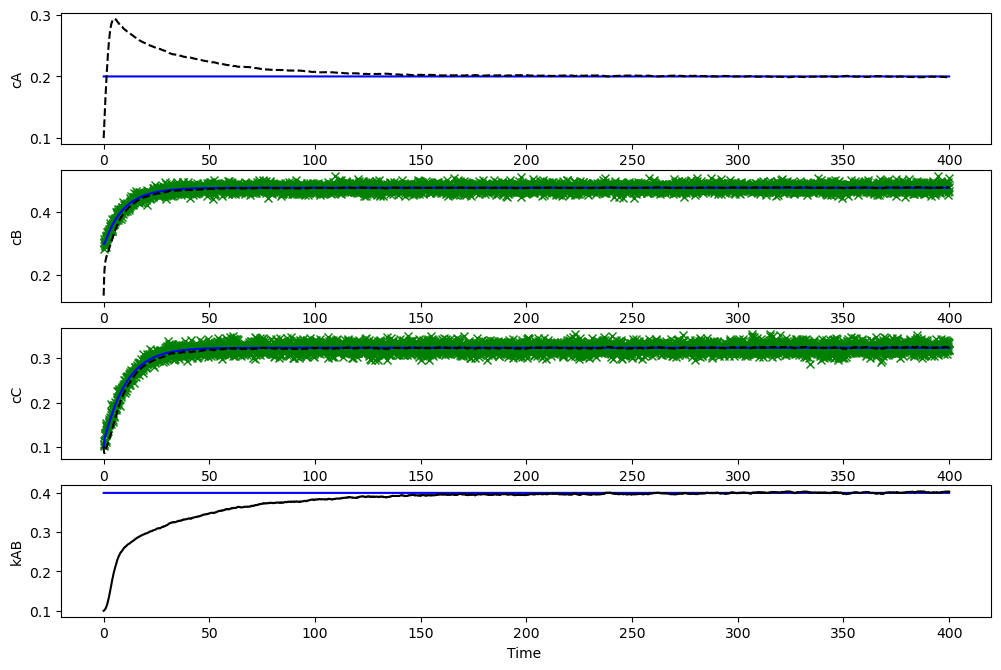

In [10]:
# Endtime
endtime = 400;

# Simulation step width
integeration_step  = 0.1;    

# Observer Initial Condition
x0_init_guess = np.array([0.1,0.1,0.1,0.1]);

# Covariance Matrix of measurement noise
R_obsv = np.diag([0.01**2,0.01**2]);

# Covariance Matrix of plant noise
q1 = 1e-7;
q2 = 1e-7;
q3 = 1e-7;
q4 = 1e-7;

# Covariance matrix of the state noise
Q = np.diag([q1,q2,q3,q4]);

# Covariance Matrix of initial error
P0 = Q*200;

# Call the discrete_EKF_filter() to get the observer estimates
[t_meas, plant_state, plant_measurement, obs_time_discrete, obs_state_discrete, obs_meas_discrete] = discrete_EKF_filter(x0_init_guess, P0, Q, R, x0, parameters, integeration_step, endtime)

# Call the plot_observer_result() function to plot the observer states
plot_observer_result('Discrete Extended Kalman Filter', parameters, t_meas, plant_state, plant_measurement, obs_time_discrete, obs_state_discrete)

<span class="graffiti-highlight graffiti-id_214uxwj-id_1hj5kx3"><i></i><button>Show Solution</button></span>
<span class="graffiti-highlight graffiti-id_uke5vz6-id_uy0kq3n"><i></i><button>Show Explanation</button></span>

To reduce the number of adjustable parameters it is suitable to chose $\mathbf{P}_0$ to be dependent
on $\mathbf{Q}$.

As you can see the tuning is quite good as the observer converges quickly to the real state values.
Thereby the convergence might also be achieved by even smaller entries of $\mathbf{Q}$, but
the error dynamic would not be that fast. On the other hand, greater entries of $\mathbf{Q}$
lead to faster observer reactions by which the measurement noise gets amplified
and the state trajectories are fluctuating around their values.

#### Task 4.2: Setting 2

Increase the integeration step to 10 and endtime to 1000. Choose the tuning parameters of the EKF same as the one given in the solution of the previous step and run the observer. Comment on the results you obtain.

Discrete Extended Kalaman Filter :

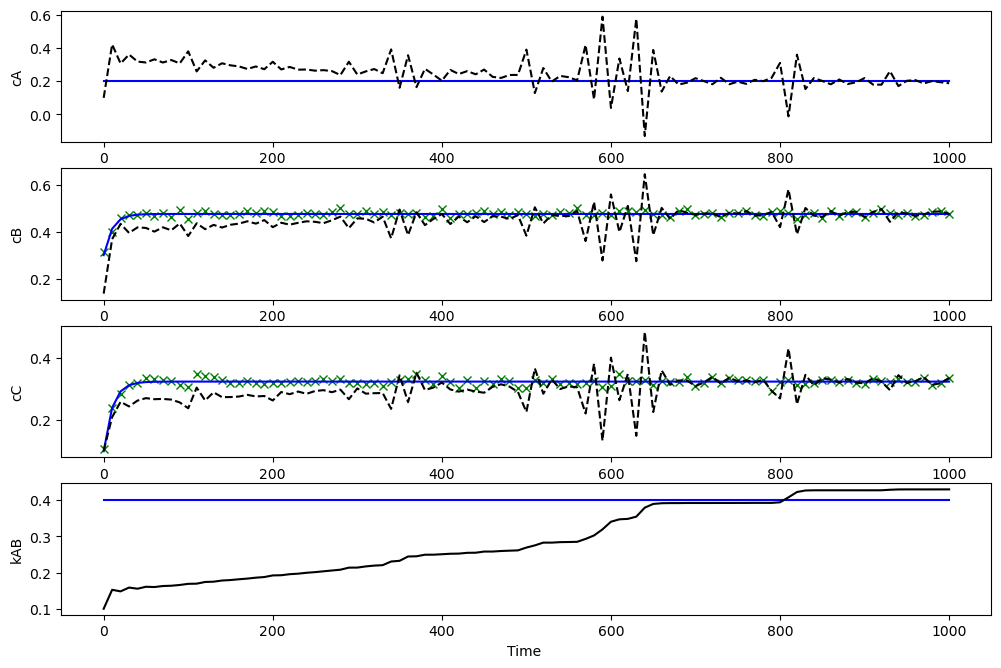

In [11]:
# Endtime
endtime = 1000;

# Simulation step width
integeration_step  = 10.;    

# Observer Initial Condition
x0_initguess = np.array([0.1,0.1,0.1,0.1]);

# Covariance Matrix of measurement noise
R_obsv = np.diag([0.01**2,0.01**2]);

# Covariance Matrix of plant noise
q1 = 1e-7;
q2 = 1e-7;
q3 = 1e-7;
q4 = 1e-7;

# Covariance matrix of the state noise
Q = np.diag([q1,q2,q3,q4]);

# Covariance Matrix of initial error
P0 = Q*200;

# Call the 
[t_meas, plant_state, plant_measurement, obs_time_discrete, obs_state_discrete, obs_meas_discrete] = discrete_EKF_filter(x0_initguess, P0, Q, R, x0, parameters, integeration_step, endtime)

plot_observer_result('Discrete Extended Kalman Filter', parameters, t_meas, plant_state, plant_measurement, obs_time_discrete, obs_state_discrete)

<span class="graffiti-highlight graffiti-id_55wb566-id_6hr31lv"><i></i><button>Show Solution</button></span>
<span class="graffiti-highlight graffiti-id_q0dlm9r-id_w3fallo"><i></i><button>Show Explanation</button></span>

#### Task 4.3: Setting 3

How do you make sure that the EKF observer works when the integeration step is chosen as 10? Implement the corrected observer and plot the results.


<span class="graffiti-highlight graffiti-id_up64pll-id_o8l341y"><i></i><button>Show Explanation</button></span>

Discrete Extended Kalaman Filter :

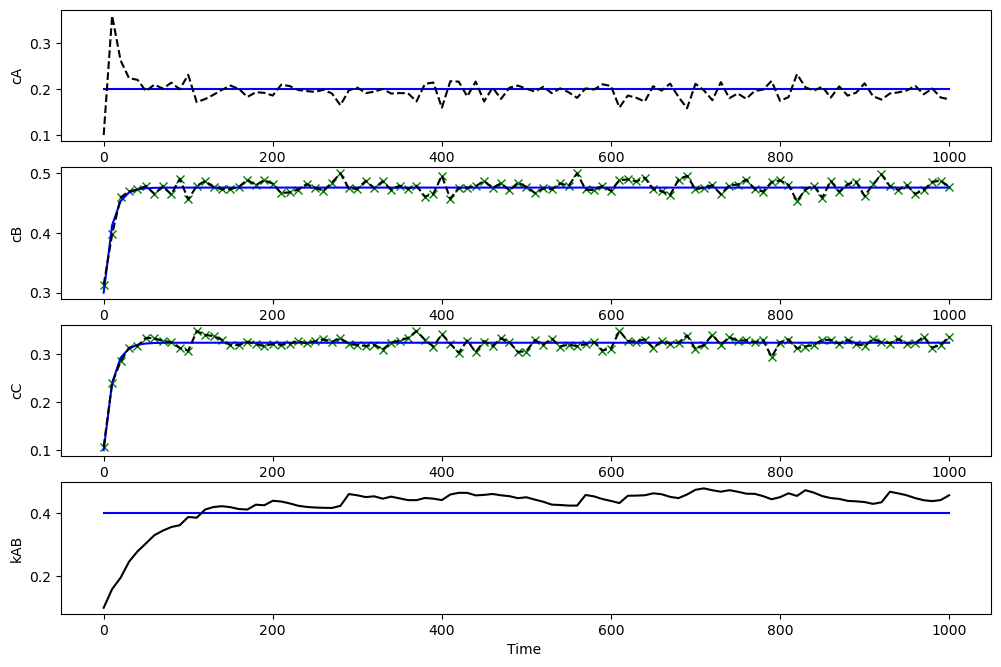

In [12]:
# Endtime
endtime = 1000;

# Simulation step width
integeration_step  = 10.;    

# Observer Initial Condition
x0_initguess = np.array([0.1,0.1,0.1,0.1]);

# Covariance Matrix of measurement noise
R_obsv = np.diag([0.01**2,0.01**2]);

# Covariance Matrix of plant noise
q1 = 1e-3;
q2 = 1e-3;
q3 = 1e-3;
q4 = 1e-3;

# Covariance matrix of the state noise
Q = np.diag([q1,q2,q3,q4]);

# Covariance Matrix of initial error
P0 = Q*200;

# Call the 
[t_meas, plant_state, plant_measurement, obs_time_discrete, obs_state_discrete, obs_meas_discrete] = discrete_EKF_filter(x0_initguess, P0, Q, R, x0, parameters, integeration_step, endtime)

plot_observer_result('Discrete Extended Kalman Filter', parameters, t_meas, plant_state, plant_measurement, obs_time_discrete, obs_state_discrete)

<span class="graffiti-highlight graffiti-id_qngp3qw-id_snht39j"><i></i><button>Show Solution</button></span>
<span class="graffiti-highlight graffiti-id_15w9jku-id_nx89khp"><i></i><button>Show Explanation</button></span>

## Task 5: Continuous Extended Kalman Filter with discrete measurements

Consider the following nonlinear dynamic system:
\begin{align}
\dot{\mathbf{x}} &= \mathbf{f}(\mathbf{x},\mathbf{u}) + \mathbf{w}(0) \\
\mathbf{x}(0) &= \mathbf{x}_0 + \mathbf{w}(0)\\
\mathbf{y}_k & = \mathbf{h}(\mathbf{x}_k) + \mathbf{v}_k
\end{align}
$\mathbf{w}(t)$ and $\mathbf{v}_k$ are assumed to be
<ul>
<li>zero mean: $E(\mathbf{w}) = E(\mathbf{v}) = 0$ </li>
<li>uncorrelated: $E(\mathbf{w}_i,\mathbf{w}_j) = E(\mathbf{v}_i,\mathbf{v}_j) = 0 \quad \forall i\neq j$ </li>
<li>distributed according to a normal distribution with covariance matrices $\mathbf{Q}$ $(\mathbf{w}_k)$, $\mathbf{R}$ $\mathbf{v}_k)$ and $\mathbf{P}_0$ $(\mathbf{w}_0))$</li>
<ul>
    
The algorithm of the discrete EKF can be divided into two steps:
<ul>

<li> <u>Correction or Measurement update </u></li>
\begin{align}
\mathbf{K}_k &= \mathbf{P}_{k,k-1} \: \mathbf{C}^T_{k,k-1}\left(\mathbf{C}_{k,k-1}\mathbf{P}_{k,k-1}\mathbf{C}^T_{k,k-1}+\mathbf{R}\right)^{-1}\\
\hat{\mathbf{x}}_{k,k} &= \hat{\mathbf{x}}_{k,k-1}+\mathbf{K}_k\left(\mathbf{y}_k-\mathbf{h}(\hat{\mathbf{x}}_{k,k-1})\right)\\
\mathbf{P}_{k,k} &= \left(I-\mathbf{K}_k\mathbf{C}_{k,k-1}\right)\mathbf{P}_{k,k-1}
\end{align}
    
<li> <u> Prediction or Time update </u> </li>
    
Based on the last corrected estimate (filtered state) $\hat{\mathbf{x}}_{k,k}$, the states for the next step are predicted by the model equations without considering disturbances:
\begin{align}
\dot{\hat{\mathbf{x}}}&= \mathbf{f}(\hat{\mathbf{x}}_{k,k},\mathbf{u}_{k})\\
 \dot{\mathbf{P}}&=\mathbf{A}(t)\mathbf{P}(t) + \mathbf{P}(t)\mathbf{A}(t)^{T} + \mathbf{Q}(t)
\end{align}
with:
\begin{align}
\mathbf{A}(t) = \left.\frac{\partial \mathbf{f}}{\partial \mathbf{x}}\right|_{\hat{\mathbf{x}}(t),\mathbf{u}(t)} \qquad \mathbf{C}_{k,k-1} = \left.\frac{\partial \mathbf{h}}{\partial \mathbf{x}}\right|_{\hat{\mathbf{x}}_k,k}
\end{align}
Both the equations are solved together using higher order numerical ODE solvers. The initial conidtion of the state and the state covariance matrix are given as 
\begin{align}
    \hat{\mathbf{x}}(t=k) &=  \hat{\mathbf{x}}_{k,k} \\
    \hat{\mathbf{P}}(t=k) &=  \hat{\mathbf{P}}_{k,k}
\end{align}
<ul>

#### Task 5.1: Continuous observer model

Create a python function which returns the continuous time observed model equations along with the linearized system matrix. A short description of the input and output arguments are given below

| Input arguments | Description |       
| :------------- |:-------------| 
| parameters      | Dictionary variable which contains the plant parameters      |

| Output arguments | Description |       
| :------------- |:-------------| 
| x      | Casadi symbolic variable which describes the observer state |
| dx | Casadi symbolic variable which describes the observer state equation     |
| A      | Casadi symbolic variable which describes the linearized system matrix of the nonlinear observer model      |

Complete the missing lines of code in the python function

<strong> Note: </strong> The jacobian of a function can be calculated using the <em> jacobian() </em> casadi function

In [14]:
def continuous_observer_model(parameters):
    # Extract the plant parameters from the input dictionary
    kBC = parameters['kBC'];
    kCB = parameters['kCB'];
    Vdot = parameters['Vdot'];
    VR = parameters['VR'];
    cAin = parameters['cAin'];

    # Generate state variable as symbolic variables
    cA = SX.sym("cA")
    cB = SX.sym("cB")
    cC = SX.sym("cC")
    kAB = SX.sym("kAB");

    # Concatenate the symbolic variables to form a state vector
    x = vertcat(cA,cB,cC,kAB)

    # Give the differential equation of the observer model
    dcA = Vdot/VR*(cAin - cA) - kAB*cA;
    dcB = -Vdot/VR * cB + kAB*cA + kCB*cC - kBC*cB**2;
    dcC = -Vdot/VR * cC + kBC*cB**2 - kCB*cC;
    dkAB = 0

    # Concatenate the differential expressions
    dx = vertcat(dcA, dcB, dcC, dkAB)

    # Linearized system matrix of the nonlinear observer model
    A = jacobian(dx, x)

    return x, dx, A

<span class="graffiti-highlight graffiti-id_q0ml005-id_49eprp3"><i></i><button>Show Solution</button></span>

#### Task 5.2: Continuous Extended Kalman Filter with discrete measurements algorithm

Create a python function which uses the above continuous Extended Kalman Filter with discrete measurements algorithm to measure the unobservable states and unknown parameters. A short description of the input and output arguments are given below

| Input arguments | Description |       
| :------------- |:-------------| 
| x0_initguess      | Initial guess for the observer states|
| P0      | EKF Tuning parameter - Initial error covariance     |
| Q | EKF Tuning parameter - State noise covariance matrix      |
| R | EKF Tuning parameter - Measurement noise covariance matrix        |
| x0 | Intial condition of the states    |
| parameters      | Dictionary variable which contains the plant parameters     |
| integeration_step | Sampling time of the plant      |
| endtime | Contains the time until which the plant measurements has to be simulated      |

| Output arguments | Description |       
| :------------- |:-------------| 
| t_meas      | All the points in time domain for which the plant measurements is simulated|
| plant_state      | True value of the plant states      |
| plant_measurement | Simulated plant measurement      |
| obs_time |  All the points in time domain for which the state estimates are available|
| obs_state | Estimated states using the observer|
| obs_meas | Estimated measurements using the observer|

Complete the missing lines of code in the python function

<strong> Note: </strong> Use <em>continuous_observer_model()</em> to obtain the continuous time observer model equations.

In [17]:
def continuous_EKF_filter(x0_initguess, P0, Q, R, x0,  parameters, integeration_step, endtime):
    # Generate plant measurements
    t_meas, plant_measurement, plant_state = simulate_plant_measurement(x0, parameters, integeration_step, endtime, R)

    # Get the continuous observer model from python function continuous_observer_model()
    x, dx, A_k = continuous_observer_model(parameters)

    # Prepare the integerator to obtain the next state estimate along with the parameter covariance matrix
    nx = 4 # number of states
    # Casadi variable that determines the state of the estimation error covariance matrix
    P = SX.sym("P", nx, nx)
    # Differential expression for estimation error covariance matrix (Obtained using Matrix Ricatti equations)
    dP = mtimes(A_k, P) + mtimes(P, A_k.T) + Q

    # Concatenate the observer state with the parameter error covariance matrix state
    xP = vertcat(x, P.reshape((nx*nx,1))) 
    
    # Concatenate the differential equation of the observer state and the parameter covariance matrix state
    dxP = vertcat(dx, dP.reshape((nx*nx,1))) 

    # Create a dictionary variable to be sent to the integerator() function
    ode = {'x':xP, 'ode':dxP}
    
    # Create a dictionary variable to set options for the integerator() function
    # Note: Here you need to integerate only until the next measurement sampling point
    opts = {"abstol": 1e-10, "reltol": 1e-10,'tf': integeration_step}

    # Integerator to obtain the state estimates and the paraemter co-variance matrix
    EKF_simulator = integrator("EKF", 'cvodes', ode, opts)

    # Current time instant
    t_est = 0;
    # Initial guess for the observer states becomes the current state estimate
    x = x0_initguess; 
    # Initial error covariance becomes the current covariance estimate
    P = P0;

    # An array of variables to save the plant states, measurements and time points
    obs_state = np.zeros((len(t_meas),len(x)));
    obs_meas = np.zeros((len(t_meas),plant_measurement.shape[1]));
    obs_time = np.zeros(len(t_meas));

    # The algorithm should be implemented in a loop to obtain a state estimate based on the observed measurements
    for j in range(len(obs_time)):
        # Measurement update / Correction
        # Kalman gain
        K = mtimes(P, mtimes(C.T, inv(mtimes(C, mtimes(P, C.T)) + R)));
        # Posteriori state estimate
        x = x + mtimes(K, (plant_measurement[j,:].T - mtimes(C,x)));  # x[k|k]
        # Posteriori estimation error covariance estimate
        P = mtimes(np.eye(nx)- mtimes(K, C), P);   # P[k|k]

        # Save the state values at t = t_meas
        obs_meas[j,:] = np.squeeze(mtimes(C, x));
        obs_state[j,:] = np.squeeze(x);
        obs_time[j] = t_est;

        # Time update / Prediction
        # Call the integerator to obtain a-priori estimate
        result = EKF_simulator(x0=vertcat(x, P.reshape((nx*nx,1))))
        # A-priori state estimate (Reshape to vector of nx*1)
        x = result['xf'][:nx]       # x[k+1|k]
        # A-priori error covariance matrix estimate (Reshape to matrix of nx*nx)
        P = result['xf'][nx:].reshape((nx,nx))       # P[k+1|k]
        
        # Increase the time point based on the integeration_step
        t_est = t_est + integeration_step; 

    return t_meas, plant_state, plant_measurement, obs_time, obs_state, obs_meas 

<span class="graffiti-highlight graffiti-id_y2m5irr-id_ys7c8zh"><i></i><button>Show Solution</button></span>

#### Task 5.3: Implementation of continuous Extended Kalman Filter with discrete measurements 

Increase the integeration step to 10 and endtime to 1000. Choose the tuning parameters of the EKF same as the one given in the solution of the <strong> Task 4.2 </strong> and run the observer. Compare the result which you obtain with the result you obtain in <strong> Task 4.3 </strong>. Comment on the observed results.

Continuous Extended Kalman Filter :

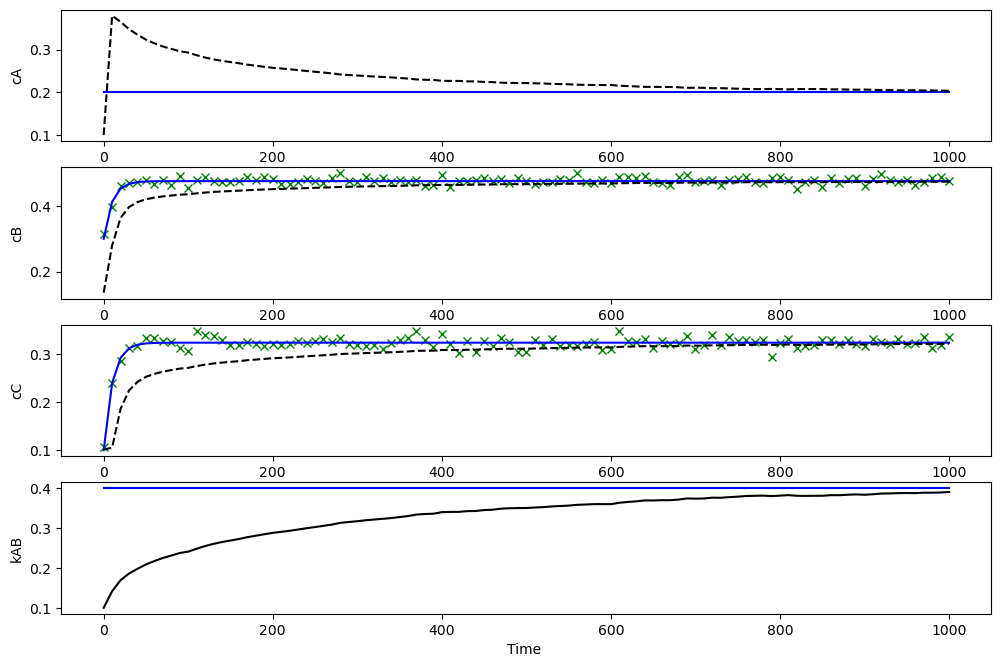

In [19]:
# Endtime
endtime = 1000;

# Simulation step width
integeration_step  = 10.;    

# Observer Initial Condition
x0_initguess = np.array([0.1,0.1,0.1,0.1]);

# Covariance Matrix of measurement noise
R_obsv = np.diag([0.01**2,0.01**2]);

# Covariance Matrix of plant noise
q1 = 1e-7;
q2 = 1e-7;
q3 = 1e-7;
q4 = 1e-7;

# Covariance matrix of the state noise
Q = np.diag([q1,q2,q3,q4]);

# Covariance Matrix of initial error
P0 = Q*200;

# Call the 
[t_meas, plant_state, plant_measurement, obs_time_discrete, obs_state_discrete, obs_meas_discrete] = continuous_EKF_filter(x0_initguess, P0, Q, R, x0, parameters, integeration_step, endtime)

plot_observer_result('Continuous Extended Kalman Filter', parameters, t_meas, plant_state, plant_measurement, obs_time_discrete, obs_state_discrete)

<span class="graffiti-highlight graffiti-id_hkqdpjt-id_w7hao3m"><i></i><button>Show Solution</button></span>
<span class="graffiti-highlight graffiti-id_cvnwse3-id_8763k7j"><i></i><button>Show Explanation</button></span>

# The End

Thank you very for following through this tutorial. We hope you are now well prepared to design an extended Kalman Filter.